In [1]:
# 14/01/2022 Luís

# A first version of the HGO model.

# Need to check if the function is working accordingly to literature. Then I will irove the function, for example
# by implementing different loads as a function of a string argument of the function.
# For now it only allows a uniaxial load, assuming incompressibility of the material.

# It accepts a list of parameters params = [c, κ, k1, k2, a01, a02], a01 and a02 being 3 dimensional vectors.
# This might not be the best solution, maybe it would be better for the function to accept more arguments
# instead of this list of params.

# Need to get the stretch-strain curves by generating some parameters, like in the other notebooks.

# 16/01/2022 Luís

# Corrected some bugs in the code.

# The function returns the Cauchy stress tensor (T) after imposing of BC (T = T - (I*T[2,2]), because I was
# expecting T[0,0] == T[2,2], and only T[1,1] should be different from 0.)

# I have encountered some problems now. 
# I'm still not very familiar with anisotropy, so I dont't yet get
# how can I define the F matrix for a uniaxial load if the material is anisotropic.
# Has can be seen in the examples below, both T[0,0] and T[1,1] are different from 0, after imposing the BC.

# Is the F matrix not valid? Or have I not imposed the BC correctly?

# I am yet to confirm if the function is working accordingly to litterature.

#17/01/2022 Joao
# Because we are applying homogeneous deformation modes (uniaxial, biaxial, simple shear etc,..), 
# F only depends on the external loads/displacements applied to the material. Thus,  F it's the same. 
# In a more complex BVP, the F of each material point is obtained by approximation methods. For instance, the FEM. 
#
# I made some simplifications in your code. let's start with only one family of fibres. 
# if the material has two families, we can simply add two HGO calls. 


# 19/01/2022 Luís
# Now the fibers do not resist any compression. Examples with only tensile stresses remained the same.
# Example 2 now outputs null stresses, as expected.

# 11/02/2022 Luís
# Now the HGO function accepts two strings: "uniaxial" and "equibiaxial".
# I've generated some combinations of parameters and corresponding curves for both uniaxial and equibiaxial
# loads (for now only 4 combinations, to reduce time spent in computations while implementing the code).
# I probably need to think better in the min and max values of the parameters.

#18/02/2022 Joao
# nice upgrades. =) 
#CHANGES THAT I'VE MADE: 
#max stretch = 1.6. with fibrous tissues such as arteries, usually this is the max stretch before rupture
# I have moved the generators to the top of the notebook. 
#I've slightly changed the HGO uniaxial output. now it outputs only an array of stresses. 
#when generating uniaxial, now we have two separate channels of data: stretch and stress. this has the advantage for model training.
#The idea is to generate data using pandas dataframes and use numpy arrays for model training.
#I've added an example for model training
#let me know if you were able to train the model in a separate file
#if you want to use the workstation you must run the train using a python script (not jupyter notebook)

#TODO: 
#change direction coordinates to just one angle - theta
#export generated uniaxial arrays to files
#do the training on a separate script
#Train a model for uniaxial and see what happens. 
#let's forget for now equibiaxial. we already now how to handle that. if uniaxial suceeds we jump into equibiaxial
#make the uniaxial unitary examples work 



# On Going: 
# Computing more curves
# Debugging/improving

In [2]:
import pandas as pd
import random

import sympy as sym
from sympy.physics.quantum import TensorProduct

import numpy as np
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', None)

In [110]:
def double_dot(A,B):
    # Double-dot operation between two 3x3 matrices
    sum = 0
    for i in range(3):
        for j in range(3):
                sum = sum + A[i,j] * B[i,j]
    return sum


def HGO(params, stretch, load):
    #returns cauchy stress at yy direction if load == "uniaxial"
    #returns cauchy stress at xx and yy directions if load == "equibiaxial"
    
    if load != 'uniaxial' and load != 'equibiaxial':
        raise ValueError("Load string isn't acceptable")
    
    #3x3 Identity Matrix
    I = sym.Matrix([[1,0,0],[0,1,0],[0,0,1]])
    
    if load == "uniaxial":
        # Deformation Gradient assuming incompressibility and a uniaxial load
        F = sym.Matrix([[1/(np.sqrt(stretch)),0,0], [0,stretch,0], [0,0,1/(np.sqrt(stretch))]])
        
  #  if load == "equibiaxial":
        # Deformation Gradient assuming incompressibility and a equibiaxial load
  #      F = sym.Matrix([[stretch,0,0], [0,stretch,0], [0,0,1/(stretch**2)]])
        
    Ft=sym.transpose(F)
    Jac=sym.det(F)
    
    # Modified Deformation Gradient
    Fm = Jac**(-1/3) * I * F
    Fmt=sym.transpose(Fm)
    
    # Modified Right Cauchy-Green Deformation Tensor with values according to F: 'Cmv'
    Cmv=Fmt*Fm

    # Symbolic Modified Right Cauchy-Green Deformation Tensor 'Cm'
    Cm11 = sym.Symbol('Cm11')
    Cm12 = sym.Symbol('Cm12')
    Cm13 = sym.Symbol('Cm13')
    Cm21 = sym.Symbol('Cm21')
    Cm22 = sym.Symbol('Cm22')
    Cm23 = sym.Symbol('Cm23')
    Cm31 = sym.Symbol('Cm31')
    Cm32 = sym.Symbol('Cm32')
    Cm33 = sym.Symbol('Cm33')
    Cm = sym.Matrix([[Cm11,Cm12,Cm13], [Cm21,Cm22,Cm23], [Cm31,Cm32,Cm33]])  
    
    # Compute the invariant im1  of the tensor Cm
    im1=sym.trace(Cm)
    
    #symbolic Neo-Hookean parameter c
    c = sym.Symbol('c')
    
    # symbolic dispersion parameter κ (0 < κ < 1/3) (the symbol is the greek letter 'kappa')
    κ = sym.Symbol('κ')
    
    # symbolic material parameters k1 and k2 (k1>0; k2>0)
    k1=sym.Symbol('k1')
    k2=sym.Symbol('k2')
    
    # Unit vector representing the direction of the fibres in the stress free configuration
    a01_1 = params[4][0]
    a01_2 = params[4][1]
    a01_3 = params[4][2]
    a01 = sym.Matrix([a01_1, a01_2, a01_3])
    
    # Structure Tensors H1, which depend on κ and a01
    
    if double_dot(Cmv, TensorProduct(a01,sym.transpose(a01))) > 1:   # condition to only allow tensile stress
        H1 = κ*I + (1-3*κ)*(TensorProduct(a01,sym.transpose(a01)))
    else:
        H1 = κ*I
        
    E1 = double_dot(H1,Cm) - 1
    
    #alternative: for debbugging 
    #m0 =TensorProduct(a01,sym.transpose(a01))
    #im4 = double_dot(Cm,m0) #pseudo-invariant 4. very important measure. it tells us the squared stretch of the fibers
    #E1 = im4*(1-3*κ) + κ*im1-1
    
    #Generate SEF (Strain Energy Function)
    sef= 0.5 * c * (im1 - 3) + (k1/(2*k2)) * (sym.exp(k2*E1*E1) - 1)
    
    #Second Piola Kirchoff Stresses
    S11=2*sym.diff(sef,Cm11)
    S12=2*sym.diff(sef,Cm12)
    S13=2*sym.diff(sef,Cm13)
    S21=2*sym.diff(sef,Cm21)
    S22=2*sym.diff(sef,Cm22)
    S23=2*sym.diff(sef,Cm23)
    S31=2*sym.diff(sef,Cm31)
    S32=2*sym.diff(sef,Cm32)
    S33=2*sym.diff(sef,Cm33)
    S = sym.Matrix([[S11,S12,S13], [S21,S22,S23], [S31,S32,S33]])
    
    
    T = (1/Jac)*(F*S*Ft) # cauchy stresses with no BCs
    T = T - (I*T[2,2]) # imposing of boundary conditions
    
    T=T.subs([(Cm11, Cmv[0,0]), (Cm12, Cmv[0,1]), 
                                  (Cm13, Cmv[0,2]),(Cm21, Cmv[1,0]), 
                                  (Cm22, Cmv[1,1]), (Cm23, Cmv[1,2]),
                                  (Cm31, Cmv[2,0]), (Cm32, Cmv[2,1]), 
                                  (Cm33, Cmv[2,2]),(c,params[0]), 
                                  (κ,params[1]),(k1,params[2]),(k2,params[3])])
    
    if load == 'uniaxial':
        return T[1,1]

#    if load == 'equibiaxial':
#        return stretch, [T[0,0],T[1,1]]

def get_curve(params, stretch_min, stretch_max, ninc, load):
    #stores HGO loading runs between a minimum and a maximum stretch
    
    if load == "uniaxial":
        stretches=np.linspace(stretch_min,stretch_max,ninc)
        stresses=[HGO(params, stretch, load) for stretch in stretches]
        return np.asarray(stresses)
#    if load == "equibiaxial":
#        lst_xx=[[stretch,HGO(params, stretch, load)[1][0]] for stretch in np.linspace(stretch_min,stretch_max,ninc)]
#        lst_yy=[[stretch,HGO(params, stretch, load)[1][1]] for stretch in np.linspace(stretch_min,stretch_max,ninc)]
#        return lst_xx, lst_yy
    
def theta_to_a01(theta):
    #defines a unit vector in the xy plane, theta degrees from the yy axis
    return [-np.sin(np.deg2rad(theta)),np.cos(np.deg2rad(theta)),0]

In [111]:
#Initial data-----------------------------------------------------------------------------------------------------

c_min = 1.0
c_max = 40.0
n_c = 1

κ_min = 0.0
κ_max = 1/3
n_κ = 2

k1_min = 0.1
k1_max = 5.0
n_k1 = 1

k2_min = 0.1
k2_max = 5.0
n_k2 = 2

theta_min = 0 # in degrees
theta_max = 90 # in degrees
n_theta = 1

decimals=2   #number of decimal cases for each parameter value

n = n_c * n_κ * n_k1 * n_k2 * n_theta # total combinations

st_max=1.6            #applied stretch
st_min=1.0
ninc=20        #number of stretch increments

#parameters grid
c_list = np.round(np.random.uniform(c_min, c_max, size = n_c), decimals)

κ_list = np.round(np.random.uniform(κ_min, κ_max, size=n_κ), decimals)

k1_list = np.round(np.random.uniform(k1_min, k1_max, size=n_k1), decimals)

k2_list = np.round(np.random.uniform(k2_min, k2_max, size=n_k2), decimals)

theta_list = np.round(np.random.uniform(theta_min, theta_max, size=n_theta), decimals)


# Computes the n combinations of params

params = []

for i in c_list:
    for j in κ_list:
        for k in k1_list:
            for l in k2_list:
                for m in a01_list:
                    params.append([i,j,k,l,m])

params = np.array(params, dtype = object)
params = params.reshape(-1, 5)
# Append the combinations to a DataFrame

df = pd.DataFrame(params[:,0], columns = ['c'])
df['κ'] = params[:,1]
df['k1'] = params[:,2]
df['k2'] = params[:,3]
df['a01'] = params[:,4]

df

# It would be nice to add a theta column. In the next version I will implement this.

a01_list = [theta_to_a01(theta) for theta in theta_list]

In [112]:
#generate uniaxial
#generate (x,y) data for each unique combination of params at the dataframe, for a uniaxial load
load = "uniaxial"
df_uniaxial = df.copy()
df_uniaxial['stretch']=df.apply(lambda x : np.linspace(st_min,st_max,ninc), axis=1)
df_uniaxial['stress']=df.apply(lambda x : get_curve(x,st_min,st_max,ninc, load), axis=1)


,c,κ,k1,k2,a01,stretch,stress
0,24.3,0.02,2.56,4.73,"[-0.39650708030655424, 0.9180316635425881, 0]","[1.0, 1.0315789473684212, 1.063157894736842, 1...","[0, 2.50544952664284, 5.06476569457592, 7.7079..."
1,24.3,0.02,2.56,0.96,"[-0.39650708030655424, 0.9180316635425881, 0]","[1.0, 1.0315789473684212, 1.063157894736842, 1...","[0, 2.50381459092692, 5.04965248026792, 7.6483..."
2,24.3,0.3,2.56,4.73,"[-0.39650708030655424, 0.9180316635425881, 0]","[1.0, 1.0315789473684212, 1.063157894736842, 1...","[0, 2.30635808880641, 4.62049273883738, 6.9471..."
3,24.3,0.3,2.56,0.96,"[-0.39650708030655424, 0.9180316635425881, 0]","[1.0, 1.0315789473684212, 1.063157894736842, 1...","[0, 2.30635764282292, 4.62048551507024, 6.9471..."


In [120]:
#get number of samples
nsamples=df_uniaxial.shape[0]
#get data channels. in this case, stretch and stress
channels = ['stretch','stress']
#number of channels
nchannels=len(channels)
#number of data points
npts=ninc
# data array
X=np.empty((nsamples,npts,nchannels))

for idx,signal in enumerate(channels):
    #convert signal to numpy
    s=df_uniaxial[signal].to_numpy()
    #flatten
    s=np.concatenate(s)
    #flatten then reshape ()
    s=s.reshape(df_uniaxial[signal].shape[0],npts)
    #append to data array
    X[:,:,idx] = s

#working with X like this will be easier to handle tensor shapes during model training 
#X = np.asarray(X).astype('float32')
X=np.asarray(X.tolist())
print(nsamples,npts,nchannels)
#len(channels)

4 20 2


In [132]:
#features, i.e., material parameters
#features
features = ['c','κ','k1','k2'] #I won't include "a0" because it will be replaced by an angle. add that later
nfeatures=len(features)
# features array
y=np.empty((nsamples,nfeatures))

for idx,signal in enumerate(features):
    #convert signal to numpy
    s=df_uniaxial[signal].to_numpy()
    #append to features array
    y[:,idx] = s #double check if it has the correct shape
#y=df1.ehertz.to_numpy()
#y=np.asarray(y.tolist())

#export X and y to approriate files.

In [133]:
#the code below should be in a separate file. it's is important to keep data generator separated from model training

#training script should start by loading X and y

#let's save 10% of the data for testing. these curves won't be part of the model training 
test_split=0.1
x_train, x_test,y_train,y_test = train_test_split(X, y,test_size = test_split)
#let's check the array shapes: 
print('Input data')
print('Training set: ',x_train.shape)
print('Test set: ',x_test.shape)
print(' ')
print('Features')
print('Training set: ',y_train.shape)
print('Test set: ',y_test.shape)
#train_size = train_df.shape[0]
#test_size = test_df.shape[0]

#reshape for keras training
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 2))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 2))
#shuffle data
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]


NameError: name 'train_test_split' is not defined

In [ ]:
# Set the hyperparameters
VALIDATION_SPLIT = 0.2
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
EPOCHS = 10
INPUT_SHAPE = x_train.shape[1:]

#model = build_model(
#    input_shape,
#    head_size=128,
#    num_heads=2,
#    ff_dim=4,
#    num_transformer_blocks=4,
#    mlp_units=[128],
#    mlp_dropout=0.4,
#    dropout=0.25,
#)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=INPUT_SHAPE),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=["mean_squared_error"],
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

history=model.fit(
    x_train,
    y_train,
    validation_split=VALIDATION_SPLIT,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
)
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

ADAPT THE CODE BELOW ACCORDINGLY TO THE MODIFICATIONS. ONLY FOR UNIAXIAL. 

In [4]:
# Example 1
# evaluated for unitary parameters. no dispersion

c= 1 # pressure units
κ = 0.0
k1 = 1.0 # pressure units
k2 = 1.0
#let's test for a simple case: fibers oriented along the pulling direction
a01 = [0,1,0]
#a01 = [-np.sin(np.deg2rad(90)),np.cos(np.deg2rad(0)),0]


params = [c, κ, k1, k2, a01]
stretch = 1.2
load = "uniaxial"

[stretch, stress] = HGO(params, stretch, load)

stress # in kPa

2.14455419836872

In [5]:
# Example 2
#evaluated for unitary parameters. no dispersion

c= 0 # pressure units
κ = 0.0
k1 = 1.0 # pressure units
k2 = 1.0
#let's test for a simple case: fibers oriented transversal to the pulling direction
a01 = [1,0,0]
#a01 = [-np.sin(np.deg2rad(90)),np.cos(np.deg2rad(0)),0]


params = [c, κ, k1, k2, a01]
stretch = 1.2
load = "uniaxial"

[stretch, stress] = HGO(params, stretch, load)

stress # in pressure units

0

In [6]:
# Example 3
# κ = 1/3, which means that the material is isotropic, i.e. Neo Hooke material.

c= 1 # pressure units
κ = 1/3
k1 = 1.0 # pressure units
k2 = 1.0
a01 = [-np.sin(np.deg2rad(65)),np.cos(np.deg2rad(65)),0]
#a02 = [np.sin(np.deg2rad(65)),np.cos(np.deg2rad(65)),0]


params = [c, κ, k1, k2, a01]
stretch = 1.2
load = "uniaxial"

[stretch, stress] = HGO(params, stretch, load)

stress  # in pressure units

0.621065104548954

In [7]:
# Example 4
# κ = 0.1, arbitrary orientation. 


c= 1.0 # pressure units
κ = 0.1
k1 = 1.0 # pressure units
k2 = 1.0
a01 = [-np.sin(np.deg2rad(65)),np.cos(np.deg2rad(65)),0]
#a02 = [np.sin(np.deg2rad(65)),np.cos(np.deg2rad(65)),0]


params = [c, κ, k1, k2, a01]
stretch = 1.2
load = "uniaxial"

[stretch, stress] = HGO(params, stretch, load)

stress  # in pressure units

0.472149517852544

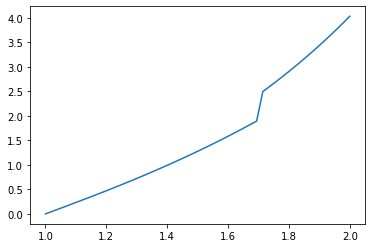

In [8]:
check = np.array(get_curve(params,1,2.0,50,"uniaxial"))
plt.plot(check[:,0],check[:,1])

Now the same examples but using an equibiaxial load

In [9]:
# Example 1
# evaluated for unitary parameters. no dispersion

c= 1 # pressure units
κ = 0.0
k1 = 1.0 # pressure units
k2 = 1.0
#let's test for a simple case: fibers oriented along the pulling direction
a01 = [0,1,0]
#a01 = [-np.sin(np.deg2rad(90)),np.cos(np.deg2rad(0)),0]


params = [c, κ, k1, k2, a01]
stretch = 1.2
load = "equibiaxial"

[stretch, stress] = HGO(params, stretch, load)

stress # xx and yy directions, in pressure units

[0.957746913580247, 2.49563444528230]

In [10]:
# Example 2
#evaluated for unitary parameters. no dispersion

c= 0 # pressure units
κ = 0.0
k1 = 1.0 # pressure units
k2 = 1.0
#let's test for a simple case: fibers oriented transversal to the pulling direction
a01 = [1,0,0]
#a01 = [-np.sin(np.deg2rad(90)),np.cos(np.deg2rad(0)),0]


params = [c, κ, k1, k2, a01]
stretch = 1.2
load = "equibiaxial"

[stretch, stress] = HGO(params, stretch, load)

stress # xx and yy directions, in pressure units

[1.53788753170205, 0]

In [11]:
# Example 3
# κ = 1/3, which means that the material is isotropic, i.e. Neo Hooke material.

c= 1 # pressure units
κ = 1/3
k1 = 1.0 # pressure units
k2 = 1.0
a01 = [-np.sin(np.deg2rad(65)),np.cos(np.deg2rad(65)),0]
#a02 = [np.sin(np.deg2rad(65)),np.cos(np.deg2rad(65)),0]


params = [c, κ, k1, k2, a01]
stretch = 1.2
load = "equibiaxial"

[stretch, stress] = HGO(params, stretch, load)

stress # xx and yy directions, in pressure units

[1.03597860272550, 1.03597860272550]

In [39]:
# Example 4
# κ = 0.1, arbitrary orientation. 


c= 1.0 # pressure units
κ = 0.1
k1 = 1.0 # pressure units
k2 = 1.0
a01 = [-np.sin(np.deg2rad(65)),np.cos(np.deg2rad(65)),0]
#a02 = [np.sin(np.deg2rad(65)),np.cos(np.deg2rad(65)),0]


params = [c, κ, k1, k2, a01]
stretch = 1.2
load = "equibiaxial"

[stretch, stress] = HGO(params, stretch, load)

stress # xx and yy directions, in pressure units

[1.67369641725395, 1.17151476945852]

In [41]:
[check_xx,check_yy] = np.array(get_curve(params,1,2.0,50,"equibiaxial"))


array([1.0, 0], dtype=object)

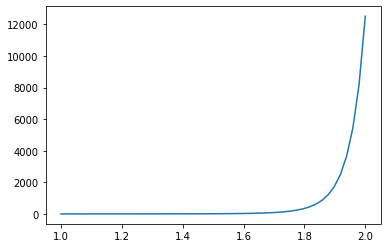

In [14]:
plt.plot(check_xx[:,0],check_xx[:,1])

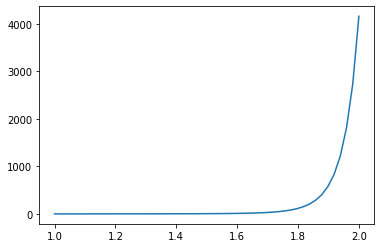

In [15]:
plt.plot(check_yy[:,0],check_yy[:,1])

array([1.0, 1.0204081632653061, 1.0408163265306123, 1.0612244897959184,
       1.0816326530612246, 1.1020408163265305, 1.1224489795918366,
       1.1428571428571428, 1.163265306122449, 1.183673469387755,
       1.2040816326530612, 1.2244897959183674, 1.2448979591836735,
       1.2653061224489797, 1.2857142857142856, 1.3061224489795917,
       1.3265306122448979, 1.346938775510204, 1.3673469387755102,
       1.3877551020408163, 1.4081632653061225, 1.4285714285714286,
       1.4489795918367347, 1.4693877551020407, 1.489795918367347,
       1.510204081632653, 1.530612244897959, 1.5510204081632653,
       1.5714285714285714, 1.5918367346938775, 1.6122448979591835,
       1.6326530612244898, 1.6530612244897958, 1.6734693877551021,
       1.693877551020408, 1.7142857142857142, 1.7346938775510203,
       1.7551020408163265, 1.7755102040816326, 1.7959183673469385,
       1.816326530612245, 1.8367346938775508, 1.8571428571428572,
       1.8775510204081631, 1.8979591836734693, 1.9183673469387754

Now we will generate several of these curves

In [16]:

#------------------------------------------------------------------------------------------------------------------

,c,κ,k1,k2,a01
0,23.75,0.18,4.71,1.99,"[-0.9716729949774241, 0.23632941169393784, 0]"
1,23.75,0.18,4.71,0.72,"[-0.9716729949774241, 0.23632941169393784, 0]"
2,23.75,0.27,4.71,1.99,"[-0.9716729949774241, 0.23632941169393784, 0]"
3,23.75,0.27,4.71,0.72,"[-0.9716729949774241, 0.23632941169393784, 0]"


In [51]:
#check_xx[:,0]
df_uniaxial['data']

0    [(1.0, 0), (1.0315789473684212, 2.138342960761...
1    [(1.0, 0), (1.0315789473684212, 2.164773081539...
2    [(1.0, 0), (1.0315789473684212, 2.201752262558...
3    [(1.0, 0), (1.0315789473684212, 2.203928996150...
Name: data, dtype: object

In [45]:
#generate (x,y) data for each unique combination of params at the dataframe, for a uniaxial load
load = "uniaxial"

df_uniaxial = df.copy()
df_uniaxial['data']=df.apply(lambda x : get_curve(x,st_min,st_max,ninc, load), axis=1)


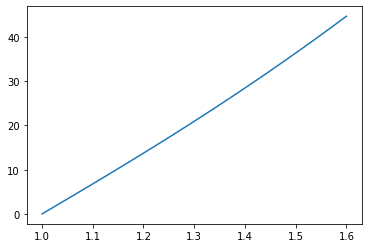

In [21]:
k = 0   #plot the curve number k

example = np.array(df_uniaxial.data[k])
plt.plot(example[:,0], example[:, 1])

In [36]:
df.apply(lambda x : get_curve(x,st_min,st_max,ninc, load), axis=1)

0    [(1.0, 0), (1.0315789473684212, 2.138342960761...
1    [(1.0, 0), (1.0315789473684212, 2.164773081539...
2    [(1.0, 0), (1.0315789473684212, 2.201752262558...
3    [(1.0, 0), (1.0315789473684212, 2.203928996150...
dtype: object

In [22]:
#generate (x,y) data for each unique combination of params at the dataframe, for a equibiaxial load
# There is stress in the xx or yy directions.
load = "equibiaxial"

df_equibiaxial = df.copy()
df_equibiaxial['data_xx']=df.apply(lambda x : get_curve(x,st_min,st_max,ninc, load)[0], axis=1)
df_equibiaxial['data_yy']=df.apply(lambda x : get_curve(x,st_min,st_max,ninc, load)[1], axis=1)
df_equibiaxial

# this doesn't seem to be very efficient, because we are applying the lambda function two times, and getting only the data
# from the xx or yy directions in each run. I've tried to get both directions from the same run of the lambda function
# but without success yet.

,c,κ,k1,k2,a01,data_xx,data_yy
0,23.75,0.18,4.71,1.99,"[-0.9716729949774241, 0.23632941169393784, 0]","[[1.0, 0], [1.0315789473684212, 4.448388398559...","[[1.0, 0], [1.0315789473684212, 4.318867003038..."
1,23.75,0.18,4.71,0.72,"[-0.9716729949774241, 0.23632941169393784, 0]","[[1.0, 0], [1.0315789473684212, 4.448202117003...","[[1.0, 0], [1.0315789473684212, 4.318844436557..."
2,23.75,0.27,4.71,1.99,"[-0.9716729949774241, 0.23632941169393784, 0]","[[1.0, 0], [1.0315789473684212, 4.335498368234...","[[1.0, 0], [1.0315789473684212, 4.309669466708..."
3,23.75,0.27,4.71,0.72,"[-0.9716729949774241, 0.23632941169393784, 0]","[[1.0, 0], [1.0315789473684212, 4.335488172021...","[[1.0, 0], [1.0315789473684212, 4.309666907442..."


In [23]:
k = 0   #plot the curve number k

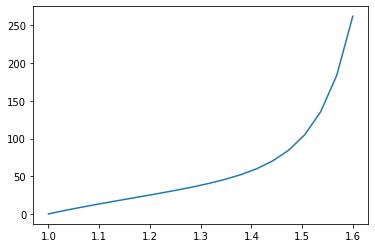

In [24]:
# xx direction
example = np.array(df_equibiaxial.data_xx[k])
plt.plot(example[:,0], example[:, 1])

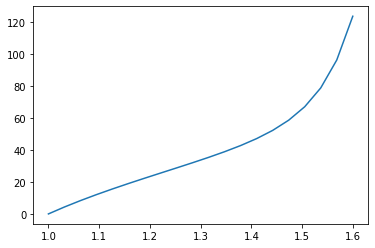

In [25]:
# yy direction
example = np.array(df_equibiaxial.data_yy[k])
plt.plot(example[:,0], example[:, 1])

In [31]:
df_uniaxial

,c,κ,k1,k2,a01,data
0,23.75,0.18,4.71,1.99,"[-0.9716729949774241, 0.23632941169393784, 0]","[(1.0, 0), (1.0315789473684212, 2.138342960761..."
1,23.75,0.18,4.71,0.72,"[-0.9716729949774241, 0.23632941169393784, 0]","[(1.0, 0), (1.0315789473684212, 2.164773081539..."
2,23.75,0.27,4.71,1.99,"[-0.9716729949774241, 0.23632941169393784, 0]","[(1.0, 0), (1.0315789473684212, 2.201752262558..."
3,23.75,0.27,4.71,0.72,"[-0.9716729949774241, 0.23632941169393784, 0]","[(1.0, 0), (1.0315789473684212, 2.203928996150..."
